In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

# Define sensor and source space

In [19]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0,0,0]])
for i in range(J.shape[-1]-1):
    J[:, i+1] = np.dot(A, J[:, i])



# Ground truth

(0, 200)

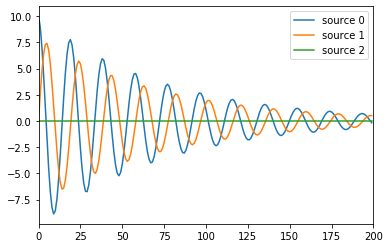

In [20]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [21]:
SC = np.array([[1,1,1], [1,1,0],[0,1,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [0 1 1]]


# Example 1: iSDR order 1

## Generate EEG/MEG data

In [22]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run ISDR

In [39]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=1e-3)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), method='lasso')
R = cl.coef_

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 2


## Get eigenvalues of MVAR model

In [40]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.937373,0.314642
eig_1,0.937373,-0.314642


## Plot effective connectivity

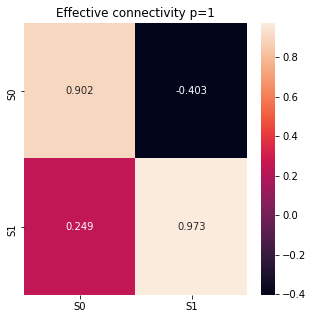

In [41]:
cl.plot_effective()

## Reconstruct the brain activation

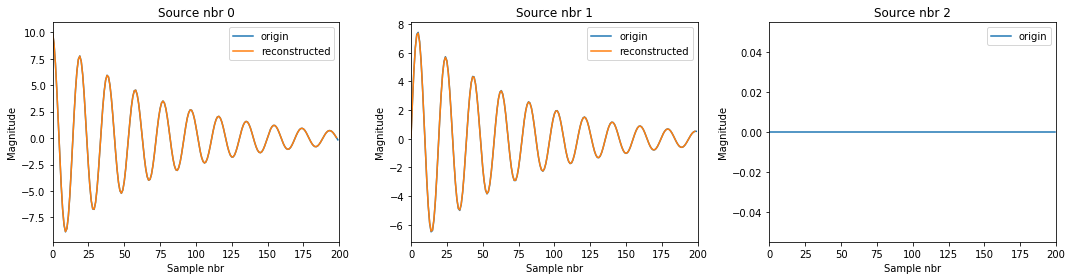

In [42]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [43]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

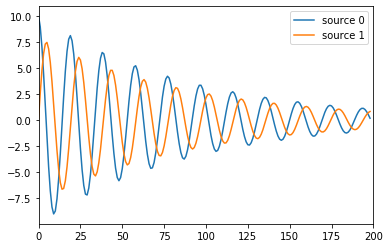

In [44]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: iSDR order 3

## Initialize MVAR model

In [45]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run iSDR

In [64]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=1e-3)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp, method='lasso')
R = cl.coef_

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 2


/Users/EEALBRB/workspace/iSDR_cython/src/iSDR_cython/linear_model.py:119: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.480713362211656, tolerance: 0.01518013969898867
  check_random_state(self.random_state), random)


## Compute eigenvalues of MVAR model

In [65]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.935803,0.314422
eig_1,0.935803,-0.314422
eig_2,-0.723980,0.629955
eig_3,-0.723980,-0.629955
eig_4,-0.194797,0.938604
eig_5,-0.194797,-0.938604


## Plot effective connectivity

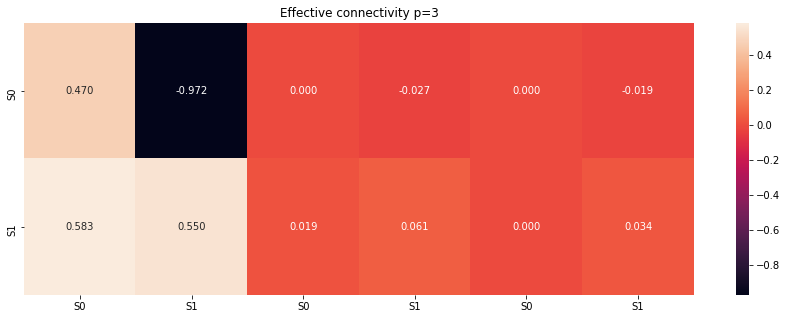

In [66]:
cl.plot_effective()

## Reconstruct the brain activation

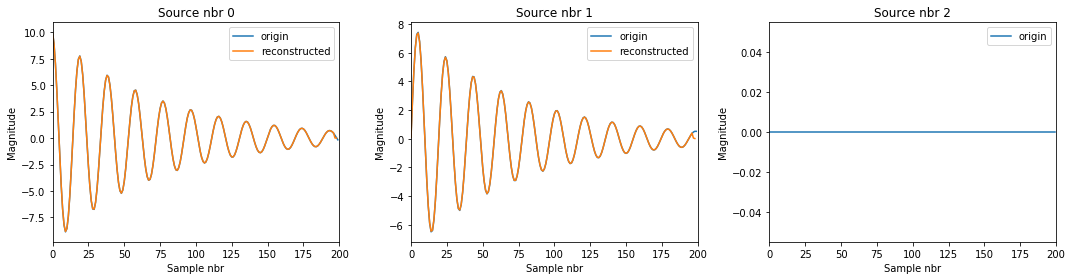

In [67]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p - 1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [68]:
for i in range(m_p, n_t):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

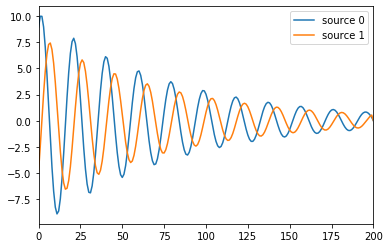

In [70]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

In [72]:
import itertools

In [78]:
for i in np.array(itertools.combinations([1], [2,3])):
    print(i)

TypeError: 'list' object cannot be interpreted as an integer

In [82]:
list1 = ["a", "b", "c"]
list2 = [1, 2]

from itertools import product

In [87]:
A = [[list1],[list2]]
list(product(A[0], A[1]))

[(['a', 'b', 'c'], [1, 2])]

In [90]:
all_comb = []
for i in product(list1,list2):
    all_comb.append(i)

In [91]:
all_comb

[('a', 1), ('a', 2), ('b', 1), ('b', 2), ('c', 1), ('c', 2)]

In [92]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [98]:
import random
import os
import uuid

def createfolder(filename):
    try:
        os.mkdir(filename)
    except OSError:
        print ("Creation of the directory %s failed" % filename)
    else:
        print ("Successfully created the directory %s " % filename)
    
def deletefolder(filname):
    try:
        os.rmdir(filename)
    except OSError:
        print ("Deletion of the directory %s failed" % filename)
    else:
        print ("Successfully deleted the directory %s" % filename) 

        
class iSDRcv():
    def __init__(self, l21_values=[], la_values = [], max_run = None,
    seed=2020, parallel=True):
        all_comb = []
        for i in product(list1,list2):
            all_comb.append(i)
        all_comb = np.array(all_comb)
        if max_run is None or max_run > len(all_comb):
            max_run = len(all_comb)
        np.random.seed(2020)
        number_list = np.arange(len(all_comb))
        random.shuffle(number_list)
        number_list = number_list[:max_run]
        self.all_comb = all_comb[number_list]
        self.parallel = parallel

    def run(self, tmp='/tmp'):
        filename = tmp + '/' + str(uuid.uuid4())
        if not os.path.exists(filename):
            createfolder(filename)
                
        self.filename = filename
        deletefolder(filename)

In [99]:
cv = iSDRcv()

In [100]:
cv.run()

Successfully created the directory /tmp/8b944ccd-c82e-42a9-b7bd-5f3095fa963f 
Successfully deleted the directory /tmp/8b944ccd-c82e-42a9-b7bd-5f3095fa963f
